In [100]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# EMC3 data reading

In [101]:
felix_folder = "/u/flr/data/EMC3-runs/W7X/EIM-SC/EFFENBERG"
# seperatrix density
# input power in seperatrix
# impurity transport coefficient
# radiation fraction of input power
# impurity type
experiment = "N03.00_P05.00_D05_C04.50-TEST"  # "N04.00_P02.50_D05_R02.00-N"  # 
#ds = xemc3.load.all(f"{felix_folder}/{experiment}")
# ds.to_netcdf(f"{experiment}.nc")

In [102]:
# everything (including geometry data)
ds = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}.nc")
# Ez only (only useful with precalculated xemc3 geom matrix)
#ds = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}_Ez.nc")

In [103]:
ds["Ezsum"] = ds["Ez"].sum(dim="Ionization", skipna=False)

<IPython.core.display.Javascript object>


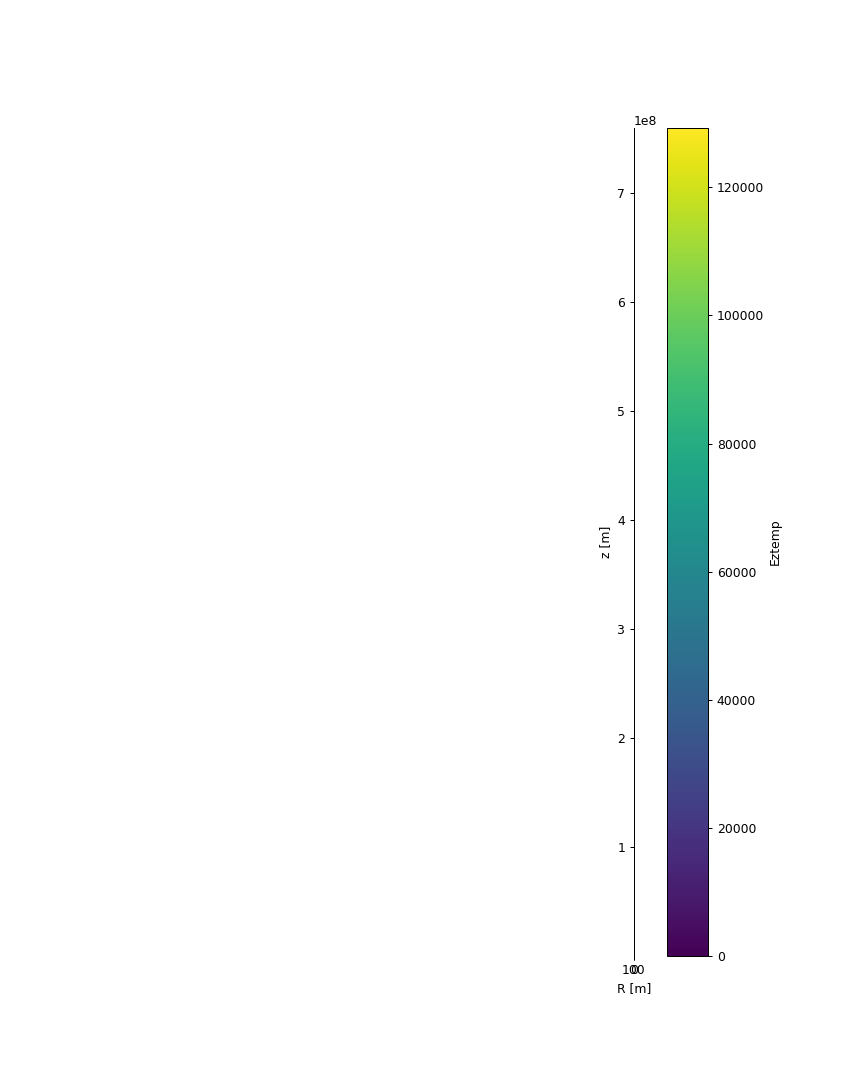

interactive(children=(FloatSlider(value=0.0, description='ip', max=0.6283185307179586, step=0.01), Output()), …

<function __main__.plot_Te(ip)>

In [137]:
plt.close("all")
import ipywidgets as widgets
fig = plt.figure(figsize=(9.5,12))
ds["Eztemp"] = ds["Ez"][4]  # np.log(ds["Ez"][5] + ds["Ez"][1] + 1e-4)  # ds["Ez"][1]

def plot_Te(ip):
    fig.clear()
    ds.emc3.plot_rz("Eztemp", phi=ip)
    
ip = widgets.FloatSlider(min=0, max=np.pi/5, value=0, step=0.01)
widgets.interact(plot_Te, ip = ip)

# Example

In [105]:
sightlines = np.load("new_gabriele_sightlines.npy", allow_pickle=True)[()]["AEE"]
A, B = sightlines["origins"][0], sightlines["hits"][0]

In [106]:
A, B

(array([-5.59566375, -3.25881329,  0.15057107]),
 array([-4.63635408, -2.7358506 , -1.7       ]))

In [107]:
prec = 1000
X = np.linspace(A[0], B[0], prec)
Y = np.linspace(A[1], B[1], prec)
Z = np.linspace(A[2], B[2], prec)

In [108]:
ds["Eztemp"] = ds["Ezsum"]
dir_vec = (B - A)/np.linalg.norm(B - A)
pos_vecs = np.array([X,Y,Z]).T - A
length = np.einsum("i,ji", dir_vec, pos_vecs) # in m

mapped = ds.emc3.evaluate_at_xyz(
    X, Y, Z, 
    key="Eztemp",
    periodicity=5, updownsym=True, delta_phi=np.pi / 1800
)
mapped.coords["dr"] = length
mapped.dr.attrs = dict(units="m", long_name="length in space")

<IPython.core.display.Javascript object>


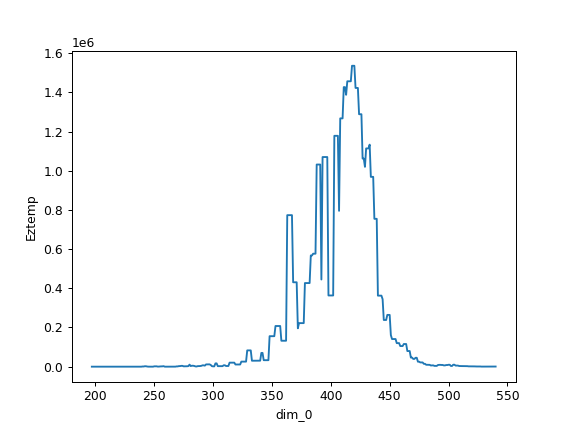

In [109]:
plt.figure()
mapped["Eztemp"].plot()
plt.show()

In [169]:
def combination_plot(bolo_name="AEE", bolo_index=0, prec=1000):
    sightlines = np.load("new_gabriele_sightlines.npy", allow_pickle=True)[()][bolo_name]
    A, B = sightlines["origins"][bolo_index], sightlines["hits"][bolo_index]
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    # plot 1
    ds["Eztemp"] = ds["Ezsum"]
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m

    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key="Eztemp",
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    mapped["Eztemp"].plot(c="grey", lw=2, zorder=100, ax=axs[0], label="sum")


    for i in range(7):
        ds["Eztemp"] = ds["Ez"][i]
        mapped = ds.emc3.evaluate_at_xyz(
            X, Y, Z, 
            key="Eztemp",
            periodicity=5, updownsym=True, delta_phi=np.pi / 1800
        )
        mapped.coords["dr"] = length
        mapped.dr.attrs = dict(units="m", long_name="length in space")
        mapped["Eztemp"].plot(c=f"C{i}", lw=0.5, zorder=i, ax=axs[0], label=f"$E^z_{i}$")
    
    axs[0].legend()
    #fig.show()
    
    # plot 2
    ds["Eztemp"] = ds["Ezsum"]  # np.log(ds["Ezsum"]+1e-4)  # ds["Ez"][4]  # 

    def plot_Te(ip, ax):
        ax.clear()
        ds.emc3.plot_rz("Eztemp", phi=ip, ax=ax)
        ax.plot([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)],
             [A[2], B[2]], c="C1")

    #sightline_phi = np.searchsorted(ds["phi_bounds"][:,1], np.arctan2(A[1], A[0]) % (2*np.pi/10))
    sight_mean_angle = (np.arctan2(A[1], A[0]) + np.arctan2(A[1], A[0]))/2
    fma = sight_mean_angle % (2*np.pi/5) # full module angle
    hmma = fma if fma < np.pi/5 else 2*np.pi/5 - fma # half module mapped angle
    plot_Te(ip=hmma, ax=axs[1])
    
    fig.tight_layout()

<IPython.core.display.Javascript object>


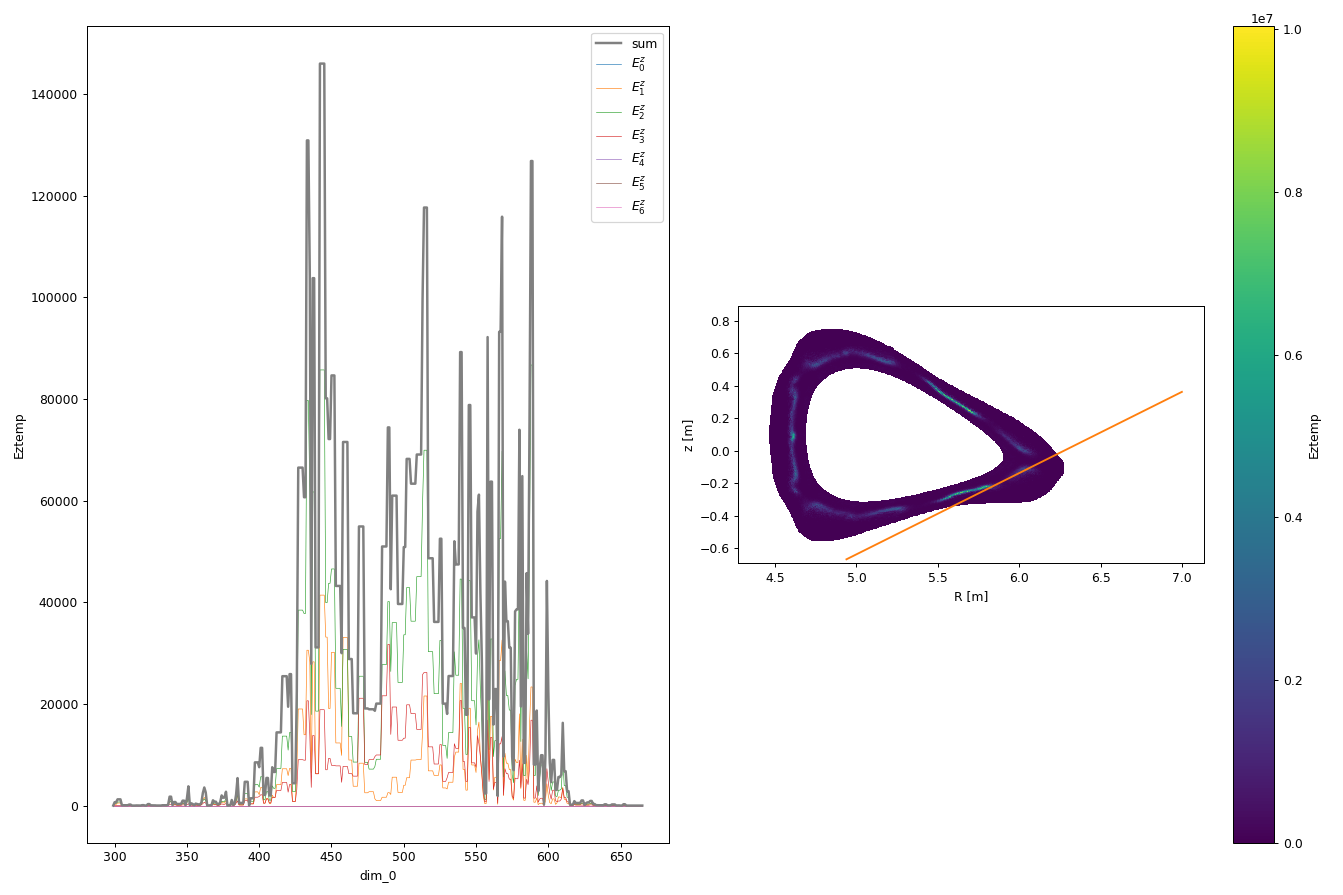

In [170]:
combination_plot(bolo_name="VBCr", bolo_index=0)

<IPython.core.display.Javascript object>


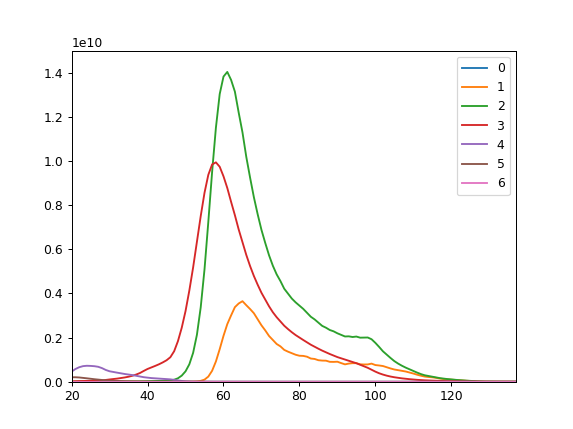

(20.0, 137.0)

In [157]:
plt.close("all")
for ion in range(7):
    plt.plot(ds.Ez.isel(Ionization=ion).sum(dim=("theta", "phi")), label=ion)
    #plt.semilogy(ds.Ez.isel(Ionization=ion).sum(dim=("theta", "phi")), label=ion)
plt.gca().legend()
plt.ylim((1e-4, 1.5e10))
plt.xlim((20, 137))

<IPython.core.display.Javascript object>


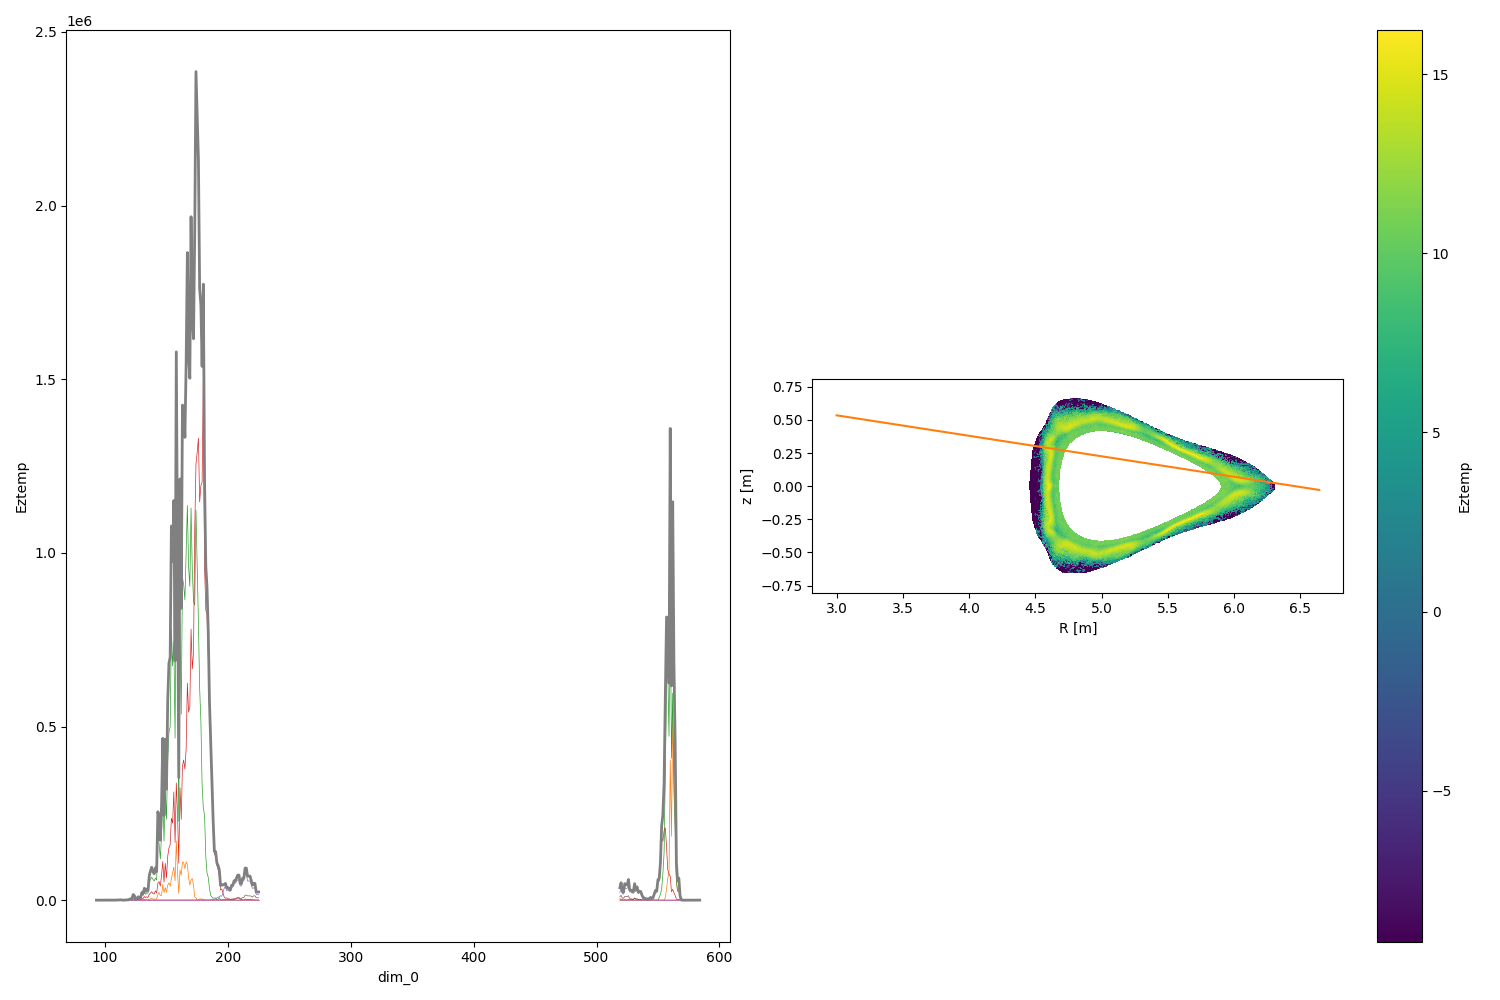

In [12]:
combination_plot(bolo_name="HBCm", bolo_index=10)

<IPython.core.display.Javascript object>


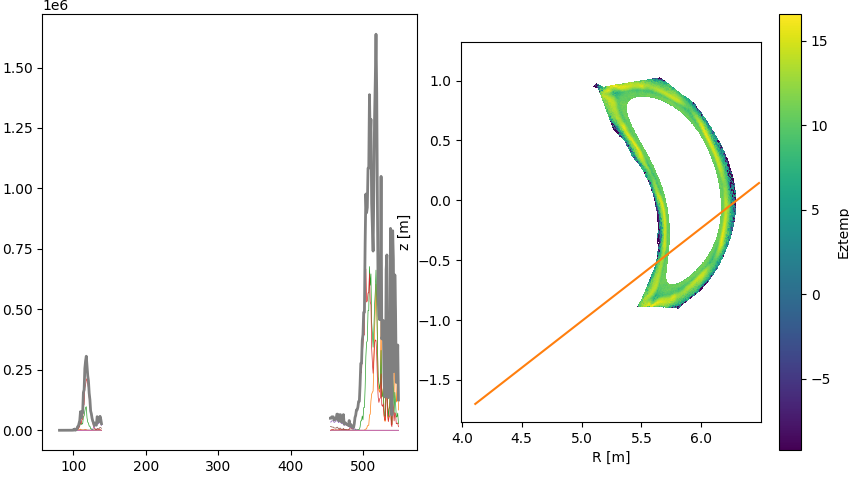

In [13]:
combination_plot(bolo_name="AEE", bolo_index=1)

In [109]:
combination_plot(bolo_name="AEE", bolo_index=2)

<IPython.core.display.Javascript object>

In [110]:
combination_plot(bolo_name="AEE", bolo_index=3)

<IPython.core.display.Javascript object>

In [111]:
combination_plot(bolo_name="AEE", bolo_index=4)

<IPython.core.display.Javascript object>

In [112]:
combination_plot(bolo_name="AEE", bolo_index=5)

<IPython.core.display.Javascript object>

In [161]:
def integrated(bolo_name="AEE", bolo_index=0, prec=1000):
    sightlines = np.load("new_gabriele_sightlines.npy", allow_pickle=True)[()][bolo_name]
    A, B = sightlines["origins"][bolo_index], sightlines["hits"][bolo_index]
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key="Ezsum",
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")

    for i in range(7):
        ds["Eztemp"] = ds["Ez"][i]
        tmp_mapped = ds.emc3.evaluate_at_xyz(
            X, Y, Z, 
            key="Eztemp",
            periodicity=5, updownsym=True, delta_phi=np.pi / 1800
        )
        mapped[f"Ez{i}"] = tmp_mapped["Eztemp"]
    
    m = mapped.sum()
    return {"Ezsum": m["Ezsum"].data[()], "Ez0": m["Ez0"].data[()], "Ez1": m["Ez1"].data[()],
            "Ez2": m["Ez2"].data[()], "Ez3": m["Ez3"].data[()], "Ez4": m["Ez4"].data[()],
            "Ez5": m["Ez5"].data[()], "Ez6": m["Ez6"].data[()],}

In [162]:
resds = integrated(bolo_name="VBCr", bolo_index=2)

In [165]:
resds["Ez4"] * 2.4405840907547515e-09,resds["Ez5"] * 2.4405840907547515e-09

(0.015615978771081377, 0.00369980053494622)

In [151]:
vals = []
for i in range(5):
    vals.append(integrated(bolo_name="AEE", bolo_index=i))

In [152]:
vals

[{'Ezsum': 78398288.43489358,
  'Ez0': 0.016961278621126567,
  'Ez1': 14759486.752964182,
  'Ez2': 50890187.5564956,
  'Ez3': 12748614.108410379,
  'Ez4': 6.195958626105299e-05,
  'Ez5': 1.6151078034340938e-07,
  'Ez6': 0.0},
 {'Ezsum': 39366422.860301524,
  'Ez0': 4.993580633831454,
  'Ez1': 9230434.016879354,
  'Ez2': 13349502.757518886,
  'Ez3': 15204793.192244463,
  'Ez4': 1309548.5317227363,
  'Ez5': 272139.3683554476,
  'Ez6': 0.0},
 {'Ezsum': 9521798.240063049,
  'Ez0': 0.00030658813313424045,
  'Ez1': 291171.7396688569,
  'Ez2': 4035882.193062537,
  'Ez3': 4714559.103066451,
  'Ez4': 410519.25731514156,
  'Ez5': 69665.94664347562,
  'Ez6': 0.0},
 {'Ezsum': 23293727.31180539,
  'Ez0': 0.0015308337547834975,
  'Ez1': 2448179.8914348157,
  'Ez2': 11698091.24288957,
  'Ez3': 8597769.997366004,
  'Ez4': 484448.37155448203,
  'Ez5': 65237.80702968561,
  'Ez6': 0.0},
 {'Ezsum': 31306827.29576628,
  'Ez0': 0.052860656649540406,
  'Ez1': 2380736.6637532692,
  'Ez2': 15620940.364156036,


# absorbed power

In [17]:
np.load("new_gabriele_sightlines.npy", allow_pickle=True)[()].keys()

dict_keys(['AEJCOR', 'AEJDIV', 'HBCm', 'VBCr', 'VBCl', 'AELBOT', 'AELTOP', 'AEM', 'AEE', 'AEU'])

In [56]:
A_all = np.load("new_gabriele_sightlines.npy", allow_pickle=True)[()]
A_0 = A_all["HBCm"]
A_1 = A_all["VBCr"]
A_2 = A_all["VBCl"]
A_labels = \
[f"HBCm Foil {i+1:02d}" for i,_ in enumerate(A_0["origins"])] + \
[f"VBCr Foil {i+1:02d}" for i,_ in enumerate(A_1["origins"])] + \
[f"VBCl Foil {i+1:02d}" for i,_ in enumerate(A_2["origins"])]

In [41]:
A_orig = np.vstack((A_0["origins"], A_1["origins"], A_2["origins"]))
A_hits = np.vstack((A_0["hits"], A_1["hits"], A_2["hits"]))

In [80]:
def integrated(orig, hit, prec=1000, only_sum=False):
    A, B = orig, hit
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key="Ezsum",
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    ) * np.mean(np.diff(length))
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    
    if not only_sum:
        for i in range(7):
            ds["Eztemp"] = ds["Ez"][i]
            tmp_mapped = ds.emc3.evaluate_at_xyz(
                X, Y, Z, 
                key="Eztemp",
                periodicity=5, updownsym=True, delta_phi=np.pi / 1800
            )
            mapped[f"Ez{i}"] = tmp_mapped["Eztemp"] * np.mean(np.diff(length))
    
    m = mapped.sum()
    if only_sum:
        return m["Ezsum"].data[()]
    
    return {"Ezsum": m["Ezsum"].data[()], "Ez0": m["Ez0"].data[()], "Ez1": m["Ez1"].data[()],
            "Ez2": m["Ez2"].data[()], "Ez3": m["Ez3"].data[()], "Ez4": m["Ez4"].data[()],
            "Ez5": m["Ez5"].data[()], "Ez6": m["Ez6"].data[()],}

In [81]:
abs_power_A = []

for orig, hit in zip(A_orig, A_hits):
    p = integrated(orig, hit, only_sum=True)
    abs_power_A.append(p)

In [82]:
abs_power_A

[38.92061781051561,
 26.60528648184481,
 584.4225125992311,
 8365.413957654542,
 628914.235722105,
 836788.2502727206,
 156615.51839768956,
 191029.73343599803,
 158350.6651123966,
 152374.0614484834,
 230339.3566239514,
 270944.21963335585,
 138468.2605823325,
 68314.68145773128,
 44820.670898722885,
 92764.26641354804,
 80447.62828429879,
 48658.568683830876,
 72904.38724184294,
 162024.2123762029,
 278816.7229878423,
 225934.2359025922,
 152497.53903453387,
 171578.5897152255,
 178755.14996067926,
 167643.33385767046,
 1092953.711044607,
 596858.2214564185,
 5150.7474168277795,
 343.92626190112463,
 40.811482278678575,
 25.081337295559823,
 21638.055736498012,
 704393.6226297341,
 177397.8652683313,
 74140.84295866014,
 61191.59688547892,
 93381.95812652241,
 172866.63806303113,
 180822.0656851643,
 184413.2489251732,
 160333.03989757076,
 119471.45925643895,
 64058.567277233924,
 54955.88120114672,
 47503.41625528191,
 99850.27954078901,
 85144.000434341,
 73617.01627440477,
 55832

<IPython.core.display.Javascript object>


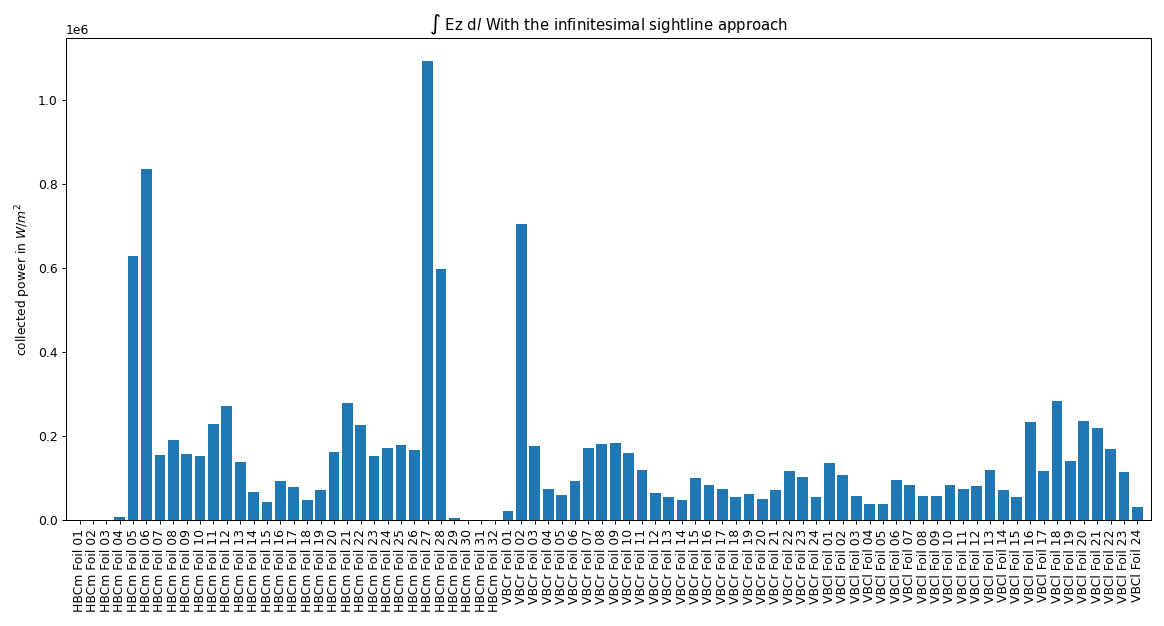

Ellipsis

In [83]:
fig, ax = plt.subplots(figsize=(13,7))
tmp_x = range(len(A_labels))


ax.bar(tmp_x, abs_power_A)
ax.set_xticks(tmp_x)
ax.set_xticklabels(A_labels, rotation=90)
ax.set_xlim(-1, len(A_labels))
ax.set_title("$\int ~ \mathrm{Ez} ~ \mathrm{d}l$ With the infinitesimal sightline approach")
ax.set_ylabel("collected power in $W/m^2$")
fig.tight_layout()
...

In [84]:
fig.savefig("../images/sightline_P.pdf")

In [85]:
fig.savefig("../images/sightline_P.jpg")

In [88]:
np.linalg.norm(A_orig - A_hits, axis=1)

array([4.11199786, 4.04825059, 3.99039771, 3.93810205, 3.88828721,
       3.84613639, 3.80827925, 3.7754325 , 3.74390905, 3.71859874,
       3.69755482, 3.68021925, 3.66573811, 3.65537324, 3.64855898,
       3.64530038, 3.64535162, 3.6487569 , 3.6556783 , 3.66617968,
       3.68147985, 3.6990698 , 3.7203672 , 3.74575454, 3.77779662,
       3.81128533, 3.84930301, 3.89193145, 3.94239618, 3.99520747,
       1.79418799, 4.11803311, 2.34796381, 2.42617879, 2.51914741,
       2.62851865, 2.76770003, 2.92065009, 3.10285461, 3.26156476,
       3.12205862, 3.01084566, 2.91738865, 2.840113  , 2.77305888,
       2.72173197, 2.68180858, 2.6527914 , 2.63247757, 2.6226113 ,
       2.62238385, 2.63175951, 2.6515174 , 2.68002247, 2.71932748,
       2.76995291, 3.01977607, 2.92379652, 2.8436424 , 2.77803687,
       2.72212489, 2.68043284, 2.6494543 , 2.62880483, 2.61704874,
       2.61519229, 2.62294082, 2.64037491, 2.66895972, 2.70642742,
       2.75537794, 2.81647631, 2.89495537, 2.98474227, 3.09250

In [89]:
A_orig - A_hits

array([[-0.53505075,  3.7056    , -1.70022814],
       [-0.57858821,  3.68384259, -1.57571327],
       [-0.62066302,  3.6637144 , -1.45438925],
       [-0.6621609 ,  3.64465856, -1.33665805],
       [-0.70249421,  3.62671295, -1.21335588],
       [-0.74133152,  3.60972907, -1.10138493],
       [-0.78057487,  3.59319034, -0.99130059],
       [-0.81771389,  3.57817261, -0.88425978],
       [-0.85932488,  3.56159176, -0.77037642],
       [-0.89678994,  3.54697038, -0.66539122],
       [-0.93321787,  3.53327788, -0.56299505],
       [-0.96976416,  3.52003865, -0.46140987],
       [-1.0087518 ,  3.50614408, -0.35638376],
       [-1.04390254,  3.49377948, -0.25598037],
       [-1.08005123,  3.48151853, -0.1565269 ],
       [-1.11511346,  3.47007664, -0.05748833],
       [-1.15666932,  3.45663594,  0.0487078 ],
       [-1.19124566,  3.44564043,  0.14806312],
       [-1.22694631,  3.43473289,  0.24737932],
       [-1.26332638,  3.42407296,  0.34728128],
       [-1.30107704,  3.4132327 ,  0.458

In [96]:
np.linalg.norm(A_all["HBCm"]["origins"][0] - A_all["HBCm"]["hits"][0])

4.111997861706748

In [97]:
np.linalg.norm(A_all["VBCl"]["origins"][-1] - A_all["VBCl"]["hits"][-1])

2.6999102403003197

In [99]:
A_all[]

dict_keys(['AEJCOR', 'AEJDIV', 'HBCm', 'VBCr', 'VBCl', 'AELBOT', 'AELTOP', 'AEM', 'AEE', 'AEU'])